
#Визуализация аналитики и построение модели для прогнозирования вероятности одобрения кредита.

In [ ]:
#загрузка всех нужных библиотек для работы программы
import numpy as np
import sklearn
import pandas as pd
import pprint
import matplotlib.pyplot as plt
import plotly
import plotly.express as px
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder, RobustScaler
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV


In [ ]:
import sklearn
print(sklearn.__version__)

1.6.0


In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

In [ ]:
!pip install -U scikit-learn xgboost

In [ ]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)


#Предварительный анализ структуры данных

In [ ]:
df = pd.read_csv("/content/loan_approval_dataset.csv")
df

,loan_id,no_of_dependents,education,self_employed,income_annum,loan_amount,loan_term,cibil_score,residential_assets_value,commercial_assets_value,luxury_assets_value,bank_asset_value,loan_status
0,1,2,Graduate,No,9600000,29900000,12,778,2400000,17600000,22700000,8000000,Approved
1,2,0,Not Graduate,Yes,4100000,12200000,8,417,2700000,2200000,8800000,3300000,Rejected
2,3,3,Graduate,No,9100000,29700000,20,506,7100000,4500000,33300000,12800000,Rejected
3,4,3,Graduate,No,8200000,30700000,8,467,18200000,3300000,23300000,7900000,Rejected
4,5,5,Not Graduate,Yes,9800000,24200000,20,382,12400000,8200000,29400000,5000000,Rejected
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4264,4265,5,Graduate,Yes,1000000,2300000,12,317,2800000,500000,3300000,800000,Rejected
4265,4266,0,Not Graduate,Yes,3300000,11300000,20,559,4200000,2900000,11000000,1900000,Approved
4266,4267,2,Not Graduate,No,6500000,23900000,18,457,1200000,12400000,18100000,7300000,Rejected
4267,4268,1,Not Graduate,No,4100000,12800000,8,780,8200000,700000,14100000,5800000,Approved


In [ ]:
#размеры
df.shape

(4269, 13)

In [ ]:
# общая информация о данных
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4269 entries, 0 to 4268
Data columns (total 13 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   loan_id                    4269 non-null   int64 
 1    no_of_dependents          4269 non-null   int64 
 2    education                 4269 non-null   object
 3    self_employed             4269 non-null   object
 4    income_annum              4269 non-null   int64 
 5    loan_amount               4269 non-null   int64 
 6    loan_term                 4269 non-null   int64 
 7    cibil_score               4269 non-null   int64 
 8    residential_assets_value  4269 non-null   int64 
 9    commercial_assets_value   4269 non-null   int64 
 10   luxury_assets_value       4269 non-null   int64 
 11   bank_asset_value          4269 non-null   int64 
 12   loan_status               4269 non-null   object
dtypes: int64(10), object(3)
memory usage: 433.7+ KB


In [ ]:
#Статистическое описание числовых данных
print(df.describe())


           loan_id   no_of_dependents   income_annum   loan_amount  \
count  4269.000000        4269.000000   4.269000e+03  4.269000e+03   
mean   2135.000000           2.498712   5.059124e+06  1.513345e+07   
std    1232.498479           1.695910   2.806840e+06  9.043363e+06   
min       1.000000           0.000000   2.000000e+05  3.000000e+05   
25%    1068.000000           1.000000   2.700000e+06  7.700000e+06   
50%    2135.000000           3.000000   5.100000e+06  1.450000e+07   
75%    3202.000000           4.000000   7.500000e+06  2.150000e+07   
max    4269.000000           5.000000   9.900000e+06  3.950000e+07   

         loan_term   cibil_score   residential_assets_value  \
count  4269.000000   4269.000000               4.269000e+03   
mean     10.900445    599.936051               7.472617e+06   
std       5.709187    172.430401               6.503637e+06   
min       2.000000    300.000000              -1.000000e+05   
25%       6.000000    453.000000               2.20000

In [ ]:
df.head(5)

,loan_id,no_of_dependents,education,self_employed,income_annum,loan_amount,loan_term,cibil_score,residential_assets_value,commercial_assets_value,luxury_assets_value,bank_asset_value,loan_status
0,1,2,Graduate,No,9600000,29900000,12,778,2400000,17600000,22700000,8000000,Approved
1,2,0,Not Graduate,Yes,4100000,12200000,8,417,2700000,2200000,8800000,3300000,Rejected
2,3,3,Graduate,No,9100000,29700000,20,506,7100000,4500000,33300000,12800000,Rejected
3,4,3,Graduate,No,8200000,30700000,8,467,18200000,3300000,23300000,7900000,Rejected
4,5,5,Not Graduate,Yes,9800000,24200000,20,382,12400000,8200000,29400000,5000000,Rejected


#Описательный анализ

In [ ]:
df.describe()

,loan_id,no_of_dependents,income_annum,loan_amount,loan_term,cibil_score,residential_assets_value,commercial_assets_value,luxury_assets_value,bank_asset_value
count,4269.000000,4269.000000,4.269000e+03,4.269000e+03,4269.000000,4269.000000,4.269000e+03,4.269000e+03,4.269000e+03,4.269000e+03
mean,2135.000000,2.498712,5.059124e+06,1.513345e+07,10.900445,599.936051,7.472617e+06,4.973155e+06,1.512631e+07,4.976692e+06
std,1232.498479,1.695910,2.806840e+06,9.043363e+06,5.709187,172.430401,6.503637e+06,4.388966e+06,9.103754e+06,3.250185e+06
min,1.000000,0.000000,2.000000e+05,3.000000e+05,2.000000,300.000000,-1.000000e+05,0.000000e+00,3.000000e+05,0.000000e+00
25%,1068.000000,1.000000,2.700000e+06,7.700000e+06,6.000000,453.000000,2.200000e+06,1.300000e+06,7.500000e+06,2.300000e+06
50%,2135.000000,3.000000,5.100000e+06,1.450000e+07,10.000000,600.000000,5.600000e+06,3.700000e+06,1.460000e+07,4.600000e+06
75%,3202.000000,4.000000,7.500000e+06,2.150000e+07,16.000000,748.000000,1.130000e+07,7.600000e+06,2.170000e+07,7.100000e+06
max,4269.000000,5.000000,9.900000e+06,3.950000e+07,20.000000,900.000000,2.910000e+07,1.940000e+07,3.920000e+07,1.470000e+07


#Преобразование
###Предобработка данных и очистка данных

In [ ]:
metadata_dict = {
    'loan_id': 'ID заявки на кредит',
    'dependents': 'количество иждивенцев',
    'education': 'уровень образования (выпускник/не выпускник)',
    'self_employed': 'статус самозанятости',
    'annual_income': 'годовой доход (самостоятельно указанный)',
    'loan_amount': 'сумма кредита',
    'loan_term': 'срок кредита в годах',
    'credit_score': 'кредитный рейтинг (по индийской системе cibil, диапазон 300-900)',
    'residential_av': 'стоимость жилых активов',
    'commercial_av': 'стоимость коммерческих активов',
    'luxury_av': 'стоимость предметов роскоши',
    'bank_av': 'стоимость банковских активов',
    'loan_status': 'статус заявки на кредит (одобрено/отказано)'
}
metadata_dict

{'loan_id': 'ID заявки на кредит',
 'dependents': 'количество иждивенцев',
 'education': 'уровень образования (выпускник/не выпускник)',
 'self_employed': 'статус самозанятости',
 'annual_income': 'годовой доход (самостоятельно указанный)',
 'loan_amount': 'сумма кредита',
 'loan_term': 'срок кредита в годах',
 'credit_score': 'кредитный рейтинг (по индийской системе cibil, диапазон 300-900)',
 'residential_av': 'стоимость жилых активов',
 'commercial_av': 'стоимость коммерческих активов',
 'luxury_av': 'стоимость предметов роскоши',
 'bank_av': 'стоимость банковских активов',
 'loan_status': 'статус заявки на кредит (одобрено/отказано)'}

In [ ]:
df.columns = ['loan_id', 'dependents', 'education', 'self_employed', 'annual_income', 'loan_amount', 'loan_term',
              'credit_score', 'residential_av', 'commercial_av', 'luxury_av', 'bank_av', 'loan_status']
df.head(2)

,loan_id,dependents,education,self_employed,annual_income,loan_amount,loan_term,credit_score,residential_av,commercial_av,luxury_av,bank_av,loan_status
0,1,2,Graduate,No,9600000,29900000,12,778,2400000,17600000,22700000,8000000,Approved
1,2,0,Not Graduate,Yes,4100000,12200000,8,417,2700000,2200000,8800000,3300000,Rejected


In [ ]:


for col in df.columns:
    pprint.pprint(col)

'loan_id'
'dependents'
'education'
'self_employed'
'annual_income'
'loan_amount'
'loan_term'
'credit_score'
'residential_av'
'commercial_av'
'luxury_av'
'bank_av'
'loan_status'


In [ ]:
print(f"В датасете {df['loan_id'].nunique()} уникальных идентификаторов кредита, каждый ID представляет собой строку в датафрейме размером {df.shape}.")


В датасете 4269 уникальных идентификаторов кредита, каждый ID представляет собой строку в датафрейме размером (4269, 13).


In [ ]:
# Удаление ненужных столбцов, удаляем столбец loan_id, так как он не несет никакой информации, а также может в будущем привести к перебоучении модели
df.drop(columns=['loan_id'], inplace=True)

In [ ]:
df = df.map(lambda x: x.strip() if isinstance(x, str) else x)

In [ ]:
#проверка пропущенных значений
print(df.isnull().sum())

dependents        0
education         0
self_employed     0
annual_income     0
loan_amount       0
loan_term         0
credit_score      0
residential_av    0
commercial_av     0
luxury_av         0
bank_av           0
loan_status       0
dtype: int64


In [ ]:
print(f"Duplicated data: {df.duplicated().sum()}")

Duplicated data: 0


In [ ]:
#отрицательные значения превращает в положительные
df['residential_av'] = df['residential_av'].abs()

In [ ]:
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (12, 6)

In [ ]:
df.describe()

,dependents,annual_income,loan_amount,loan_term,credit_score,residential_av,commercial_av,luxury_av,bank_av
count,4269.000000,4.269000e+03,4.269000e+03,4269.000000,4269.000000,4.269000e+03,4.269000e+03,4.269000e+03,4.269000e+03
mean,2.498712,5.059124e+06,1.513345e+07,10.900445,599.936051,7.473928e+06,4.973155e+06,1.512631e+07,4.976692e+06
std,1.695910,2.806840e+06,9.043363e+06,5.709187,172.430401,6.502129e+06,4.388966e+06,9.103754e+06,3.250185e+06
min,0.000000,2.000000e+05,3.000000e+05,2.000000,300.000000,0.000000e+00,0.000000e+00,3.000000e+05,0.000000e+00
25%,1.000000,2.700000e+06,7.700000e+06,6.000000,453.000000,2.200000e+06,1.300000e+06,7.500000e+06,2.300000e+06
50%,3.000000,5.100000e+06,1.450000e+07,10.000000,600.000000,5.600000e+06,3.700000e+06,1.460000e+07,4.600000e+06
75%,4.000000,7.500000e+06,2.150000e+07,16.000000,748.000000,1.130000e+07,7.600000e+06,2.170000e+07,7.100000e+06
max,5.000000,9.900000e+06,3.950000e+07,20.000000,900.000000,2.910000e+07,1.940000e+07,3.920000e+07,1.470000e+07


Большая доля заявок на кредит успешно одобряется, что может свидетельствовать о высоких стандартах отбора клиентов банком, если данные предварительно фильтруются.

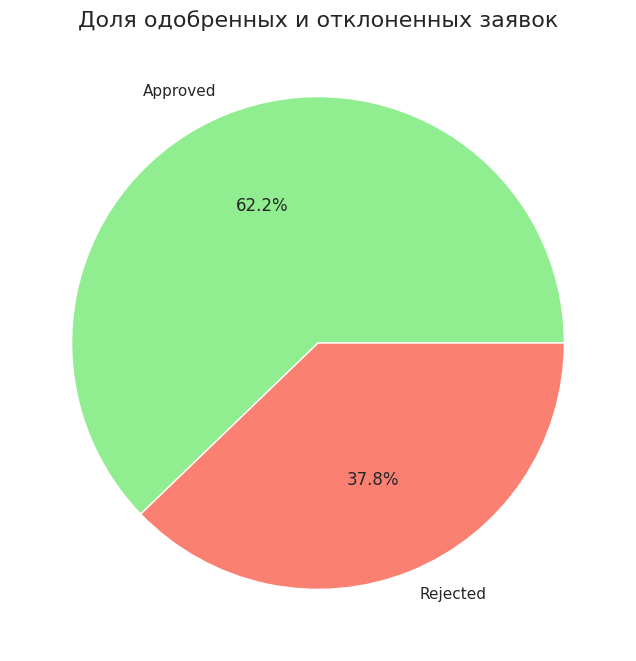

In [ ]:
loan_status_counts = df['loan_status'].value_counts(normalize=True)
loan_status_counts.plot(kind='pie', autopct='%1.1f%%', colors=['lightgreen', 'salmon'], figsize=(8, 8))
plt.title('Доля одобренных и отклоненных заявок', fontsize=16)
plt.ylabel('')  # Убираем подпись оси
plt.show()



Approved (Одобрено): У заявителей с одобренными кредитами медианный кредитный рейтинг значительно выше (около 700), а большинство значений находится в диапазоне 600-800. Это подтверждает, что высокий кредитный рейтинг положительно влияет на одобрение.
Rejected (Отклонено): У заявителей с отклоненными кредитами медианный рейтинг ниже (около 600), и диапазон значений смещен в сторону более низких значений.Кредитный рейтинг является одним из значительных факторов, влияющих на одобрение заявки. Заявители с низким рейтингом (меньше 600) с большей вероятностью получат отказ.

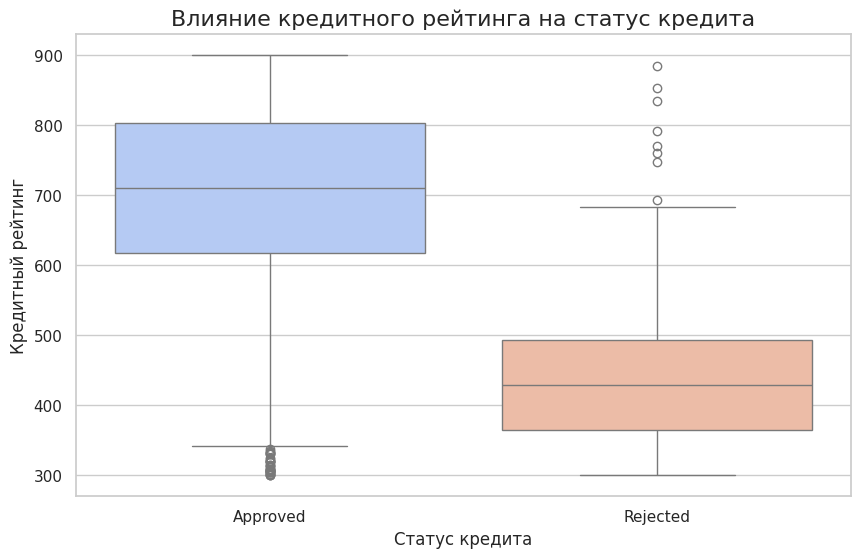

In [ ]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='loan_status', y='credit_score', palette='coolwarm')
plt.title('Влияние кредитного рейтинга на статус кредита', fontsize=16)
plt.xlabel('Статус кредита', fontsize=12)
plt.ylabel('Кредитный рейтинг', fontsize=12)
plt.show()


Для одобренных заявок (Approved) виден плавный пик в среднем диапазоне доходов.
Для отклоненных заявок (Rejected) распределение более равномерное, но частота заметно падает в верхнем диапазоне доходов.
Годовой доход является одним из факторов, влияющих на одобрение кредита. Клиенты с более высоким доходом имеют больше шансов получить одобрение.

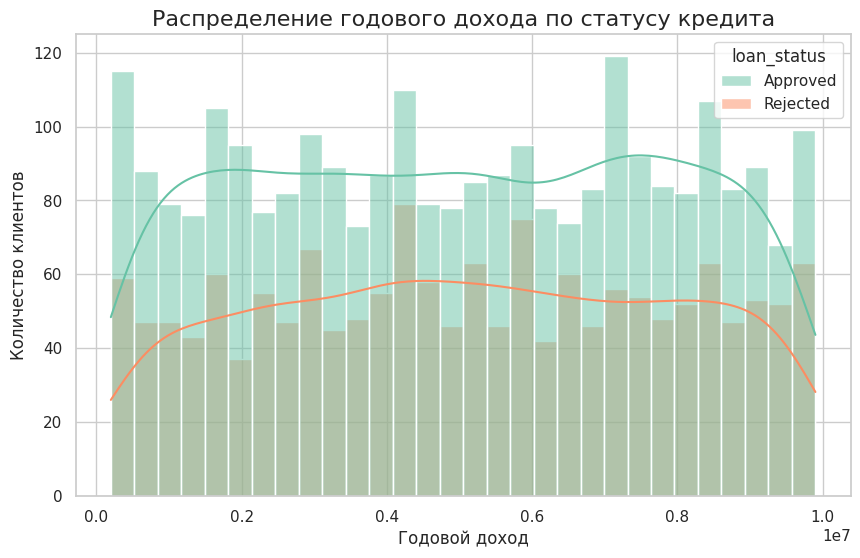

In [ ]:
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='annual_income', hue='loan_status', kde=True, palette='Set2', bins=30)
plt.title('Распределение годового дохода по статусу кредита', fontsize=16)
plt.xlabel('Годовой доход', fontsize=12)
plt.ylabel('Количество клиентов', fontsize=12)
plt.show()


вывод : кредитные организации могут быть более лояльны к заемщикам с иждивенцами.

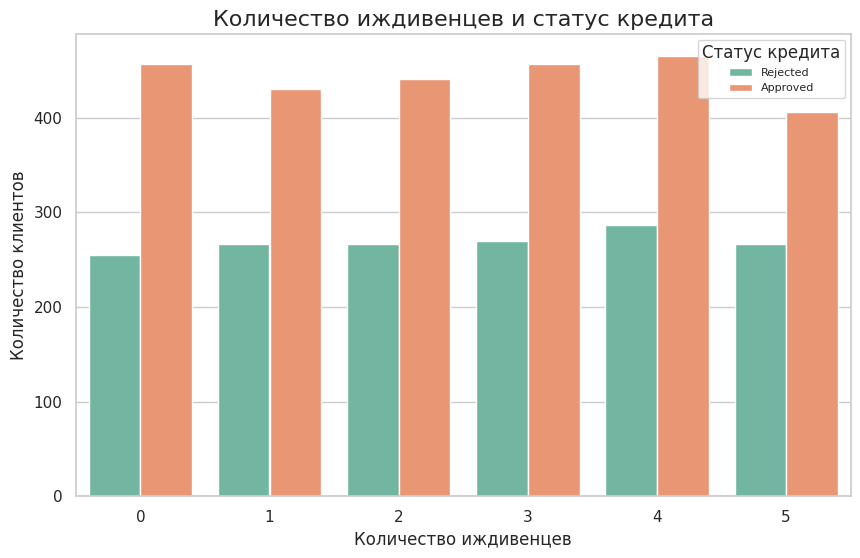

In [ ]:
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='dependents', hue='loan_status', palette='Set2')
plt.title('Количество иждивенцев и статус кредита', fontsize=16)
plt.xlabel('Количество иждивенцев', fontsize=12)
plt.ylabel('Количество клиентов', fontsize=12)
plt.legend(title='Статус кредита',fontsize=8 )
plt.show()

Заемщики с более высоким доходом получают более высокие суммы кредитов.
Разделение по цвету позволяет легко различить одобренные и отклоненные кредиты. Кредиты с высоким доходом чаще одобряются. Размер точек, связанный с количеством зависимых, может показывать, что заемщики с большим количеством зависимых могут получать кредиты меньших размеров или с большими трудностями при одобрении.

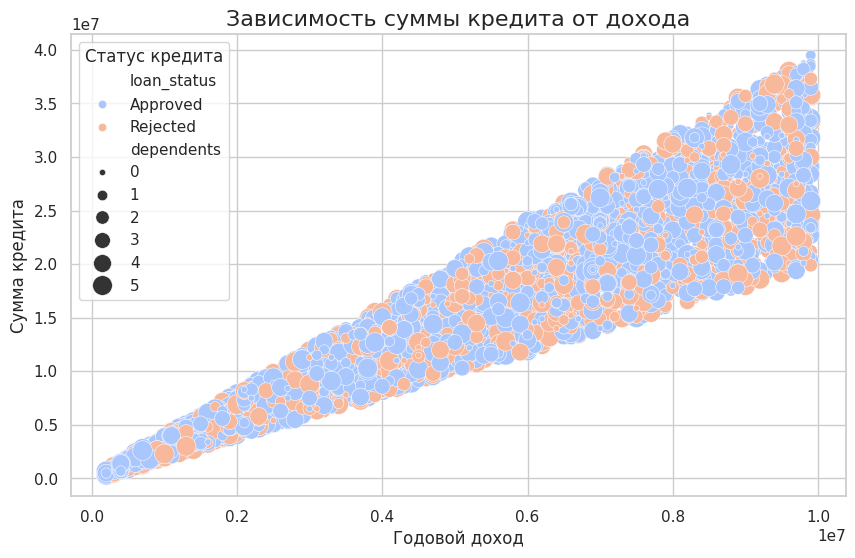

In [ ]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='annual_income', y='loan_amount', hue='loan_status', size='dependents', sizes=(20, 200), palette='coolwarm')
plt.title('Зависимость суммы кредита от дохода', fontsize=16)
plt.xlabel('Годовой доход', fontsize=12)
plt.ylabel('Сумма кредита', fontsize=12)
plt.legend(title='Статус кредита')
plt.show()


Доля одобренных и отклоненных заявок помогает увидеть сототношение

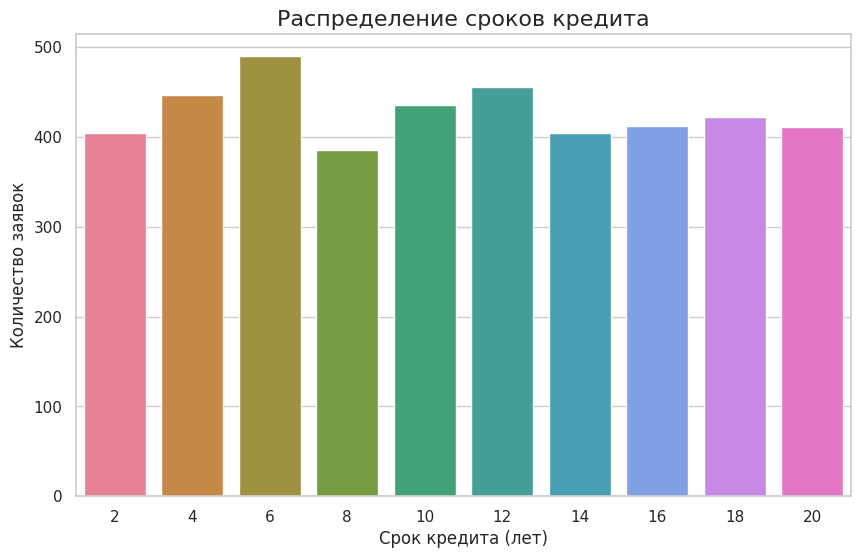

In [ ]:
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='loan_term', palette='husl')
plt.title('Распределение сроков кредита', fontsize=16)
plt.xlabel('Срок кредита (лет)', fontsize=12)
plt.ylabel('Количество заявок', fontsize=12)
plt.show()

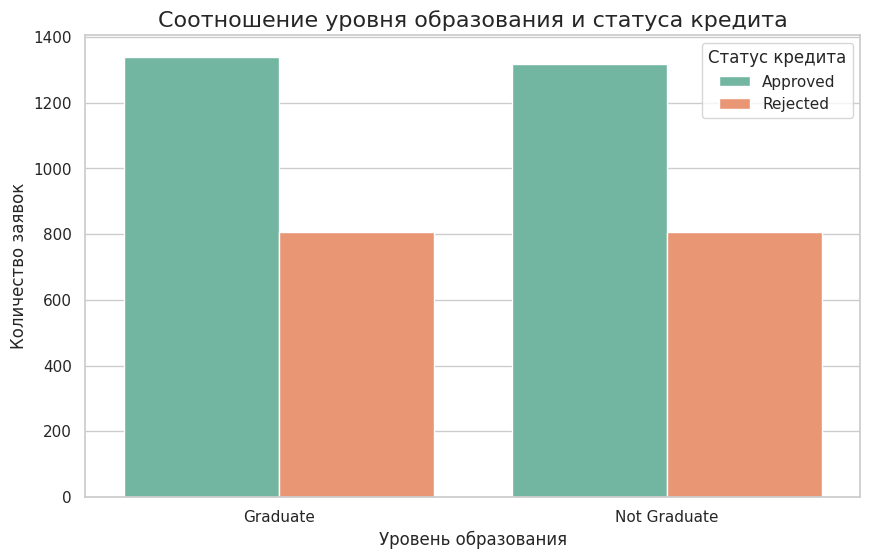

In [ ]:
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='education', hue='loan_status', palette='Set2')
plt.title('Соотношение уровня образования и статуса кредита', fontsize=16)
plt.xlabel('Уровень образования', fontsize=12)
plt.ylabel('Количество заявок', fontsize=12)
plt.legend(title='Статус кредита')
plt.show()


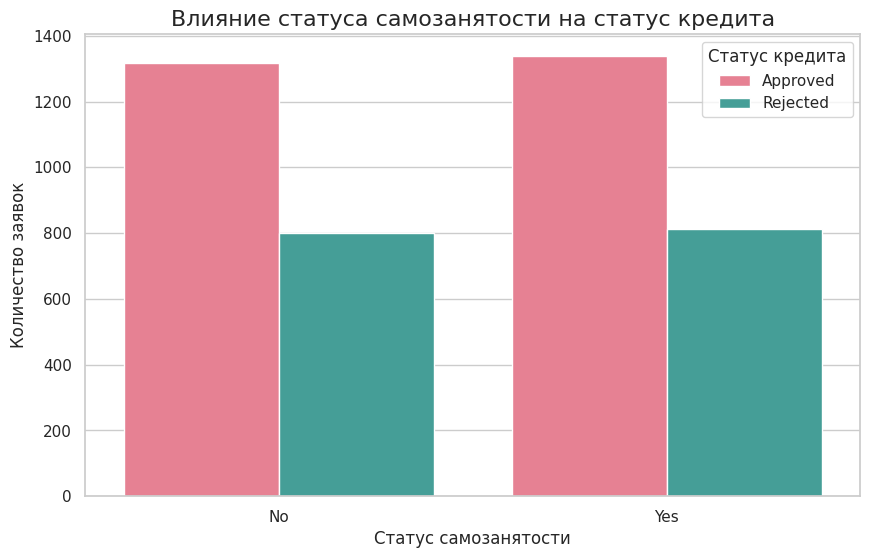

In [ ]:
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='self_employed', hue='loan_status', palette='husl')
plt.title('Влияние статуса самозанятости на статус кредита', fontsize=16)
plt.xlabel('Статус самозанятости', fontsize=12)
plt.ylabel('Количество заявок', fontsize=12)
plt.legend(title='Статус кредита')
plt.show()


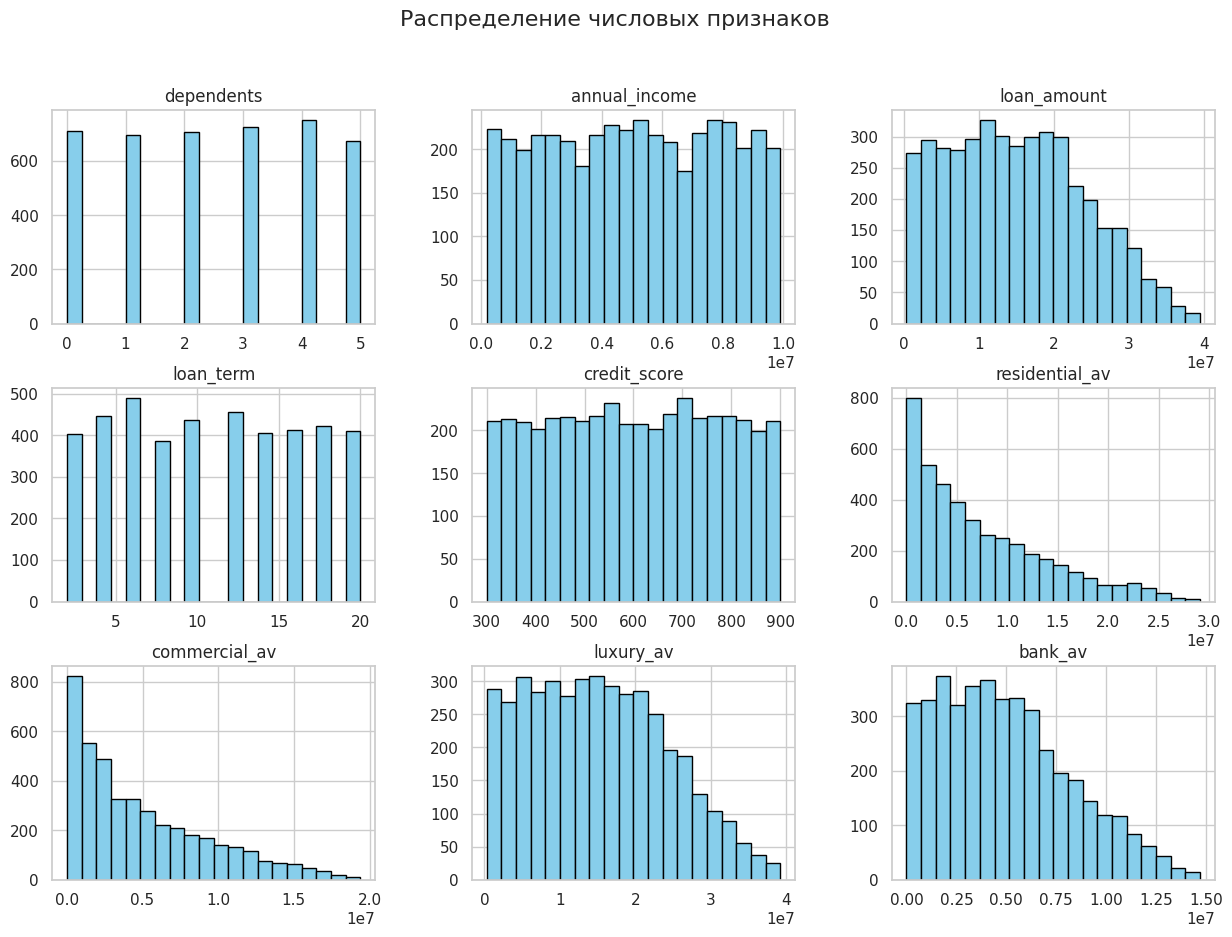

In [ ]:
# 2. Гистограмма для числовых переменных
numeric_columns = df.select_dtypes(include=["int64", "float64"]).columns
df[numeric_columns].hist(bins=20, figsize=(15, 10), color="skyblue", edgecolor="black")
plt.suptitle("Распределение числовых признаков", fontsize=16)
plt.show()

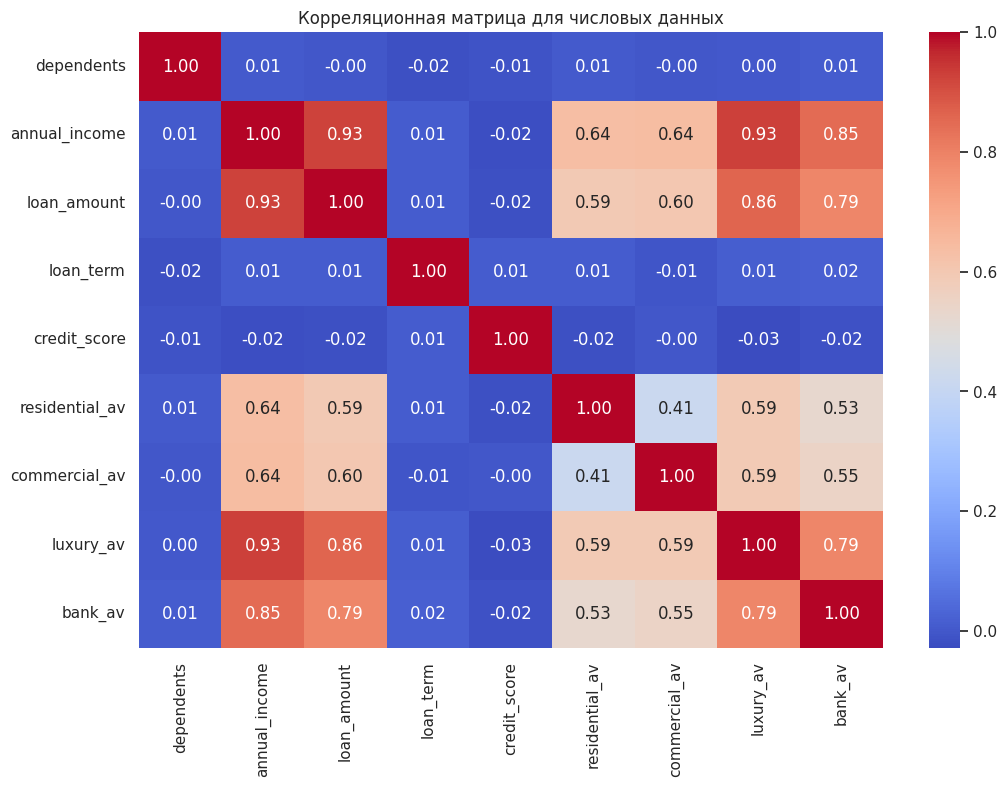

In [ ]:
numeric_columns = df.select_dtypes(include=["int64", "float64"]).columns
correlation_matrix = df[numeric_columns].corr()

# Визуализация
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Корреляционная матрица для числовых данных")
plt.show()

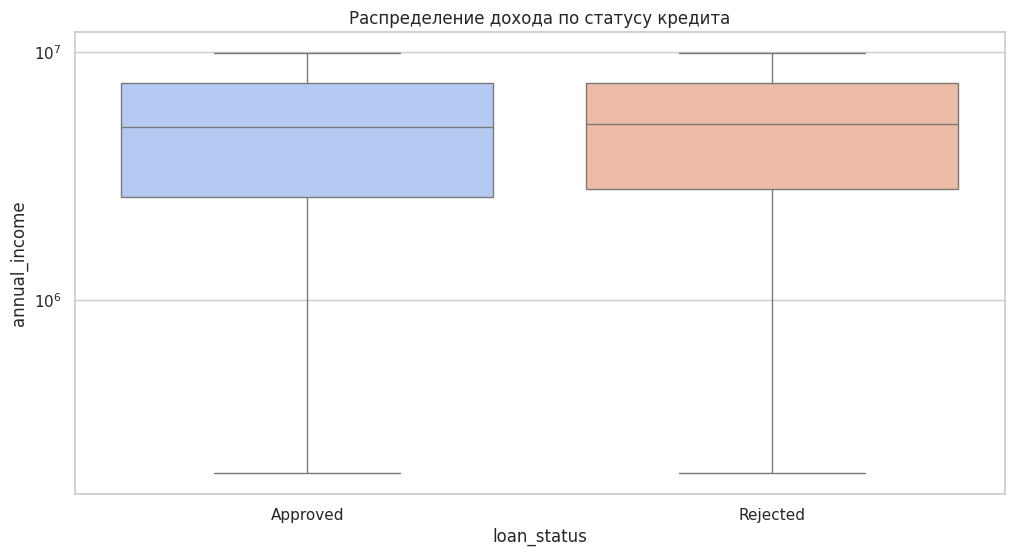

In [ ]:
# 4. Boxplot для анализа распределения дохода по статусу кредита
sns.boxplot(data=df, x="loan_status", y="annual_income", palette="coolwarm")
plt.title("Распределение дохода по статусу кредита")
plt.yscale("log")  # Логарифмическая шкала для лучшей читаемости
plt.show()

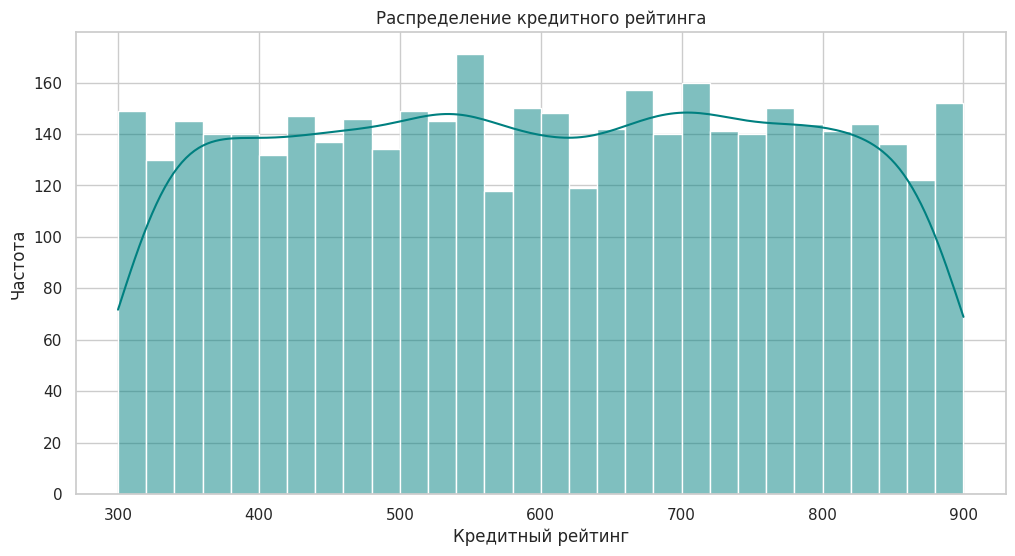

In [ ]:
# 5. Распределение кредитного рейтинга
sns.histplot(df['credit_score'], kde=True, bins=30, color="teal")
plt.title("Распределение кредитного рейтинга")
plt.xlabel("Кредитный рейтинг")
plt.ylabel("Частота")
plt.show()


In [ ]:
# 8. Интерактивный график для кредитного рейтинга и статуса кредита
fig = px.box(df, x="loan_status", y="credit_score", points="all", color="loan_status",
             title="Распределение кредитного рейтинга по статусу кредита")
fig.show()

Элитные активы значительно превышают стоимость других типов активов. Они могут быть ключевым драйвером общего портфеля активов.
Жилая недвижимость также представляет существенную часть общей стоимости, занимая вторую позицию.
Коммерческая недвижимость и банковские активы имеют сравнительно меньшую стоимость, что может указывать на их более ограниченное влияние или меньшую долю в портфеле активов.


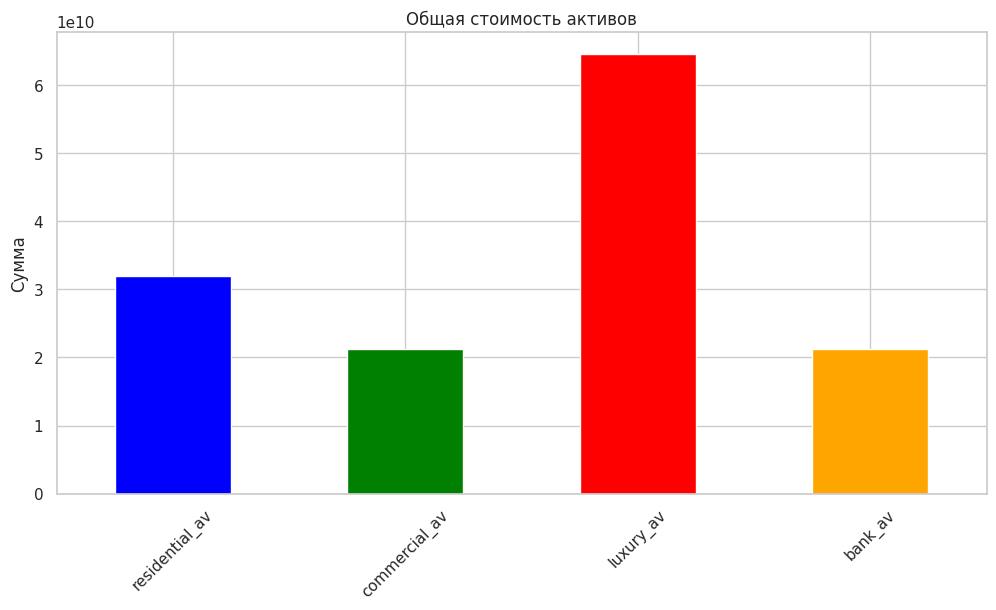

In [ ]:
# 9. Анализ стоимости активов
asset_columns = ["residential_av", "commercial_av", "luxury_av", "bank_av"]
df[asset_columns].sum().plot(kind="bar", color=["blue", "green", "red", "orange"])
plt.title("Общая стоимость активов")
plt.ylabel("Сумма")
plt.xticks(rotation=45)
plt.show()

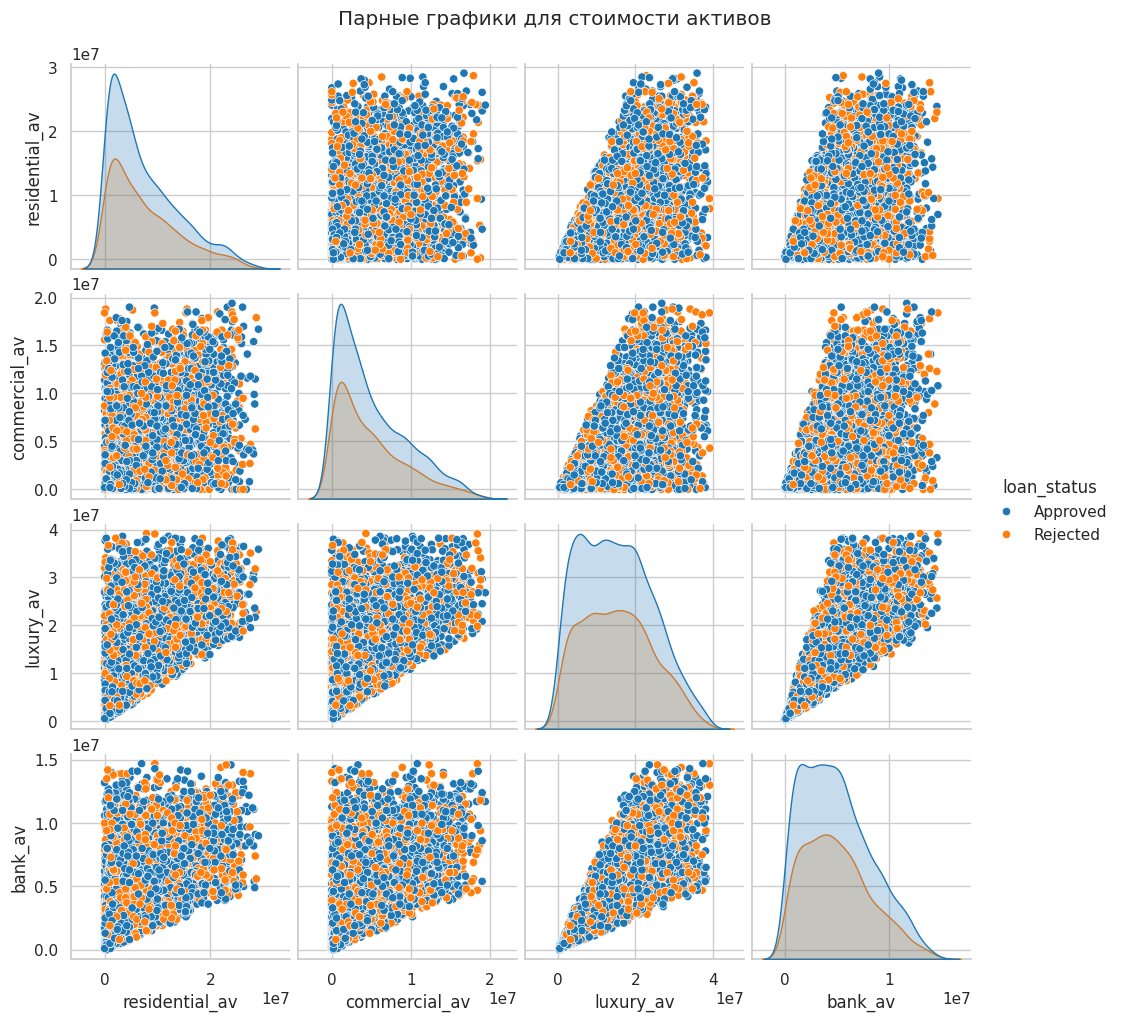

In [ ]:
# 10. Взаимосвязь различных активов
sns.pairplot(df[asset_columns + ["loan_status"]], hue="loan_status", palette="tab10")
plt.suptitle("Парные графики для стоимости активов", y=1.02)
plt.show()

###Машинное обучение

In [ ]:
# Кодирование категориальных переменных
categorical_columns = ['education', 'self_employed', 'loan_status']
label_encoders = {}


In [ ]:
from sklearn.preprocessing import LabelEncoder

label_encoders = {}
for col in categorical_columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

In [ ]:
 #Нормализация числовых данных
scaler = RobustScaler()
numerical_columns = ['annual_income', 'loan_amount', 'loan_term', 'credit_score',
                     'residential_av', 'commercial_av', 'luxury_av', 'bank_av']
df[numerical_columns] = scaler.fit_transform(df[numerical_columns])



In [ ]:
# Разделение данных на признаки и целевую переменную
X = df.drop(columns=['loan_status'])
y = df['loan_status']


In [ ]:
from sklearn.preprocessing import LabelEncoder

label_encoders = {}
categorical_columns = ['education', 'self_employed', 'loan_status']

for col in categorical_columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

In [ ]:
# Разделение на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)



In [ ]:
df = df[df['credit_score'] >= 300]  # Удаление данных с низким кредитным рейтингом


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier



#1. Логистическая регрессия

In [ ]:
model_lr = LogisticRegression(max_iter=1000)


In [ ]:
# Обучение модели
model_lr.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

In [ ]:
y_pred = model_lr.predict(X_test)

In [ ]:
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.4f}')

Accuracy: 0.9227


In [ ]:
# Подробный отчет
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.92      0.95      0.94       531
           1       0.92      0.87      0.89       323

    accuracy                           0.92       854
   macro avg       0.92      0.91      0.92       854
weighted avg       0.92      0.92      0.92       854



In [ ]:
# Матрица ошибок
cm = confusion_matrix(y_test, y_pred)
print(f'Confusion Matrix:\n{cm}')

Confusion Matrix:
[[507  24]
 [ 42 281]]


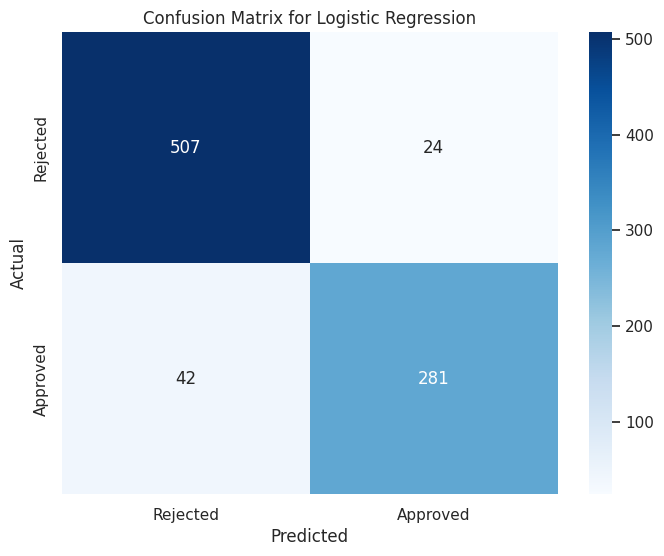

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Визуализация матрицы ошибок
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Rejected', 'Approved'], yticklabels=['Rejected', 'Approved'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for Logistic Regression')
plt.show()


Логистическая регрессия с оптимизацией гиперпараметров

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

# Определение параметров для поиска
param_grid_lr = {
    'penalty': ['l1', 'l2', 'elasticnet', 'none'],
    'C': [0.01, 0.1, 1, 10, 100],
    'solver': ['lbfgs', 'liblinear', 'saga']
}

# Инициализация модели
model_lr = LogisticRegression(max_iter=1000, random_state=42)

# Оптимизация гиперпараметров с помощью GridSearchCV
grid_search_lr = GridSearchCV(estimator=model_lr, param_grid=param_grid_lr, cv=5, scoring='accuracy')
grid_search_lr.fit(X_train, y_train)

# Лучшая комбинация гиперпараметров
print("Best parameters for Logistic Regression:", grid_search_lr.best_params_)

# Прогнозирование на тестовой выборке с оптимизированными гиперпараметрами
y_pred_lr = grid_search_lr.best_estimator_.predict(X_test)

# Оценка эффективности модели
accuracy_lr = accuracy_score(y_test, y_pred_lr)
print(f'Accuracy for Logistic Regression with tuned parameters: {accuracy_lr:.4f}')


Best parameters for Logistic Regression: {'C': 0.01, 'penalty': 'l1', 'solver': 'liblinear'}
Accuracy for Logistic Regression with tuned parameters: 0.9344


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning:


175 fits failed out of a total of 300.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
25 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 1193, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "

Оценка эффективности

              precision    recall  f1-score   support

           0       0.95      0.95      0.95       531
           1       0.91      0.92      0.91       323

    accuracy                           0.93       854
   macro avg       0.93      0.93      0.93       854
weighted avg       0.93      0.93      0.93       854



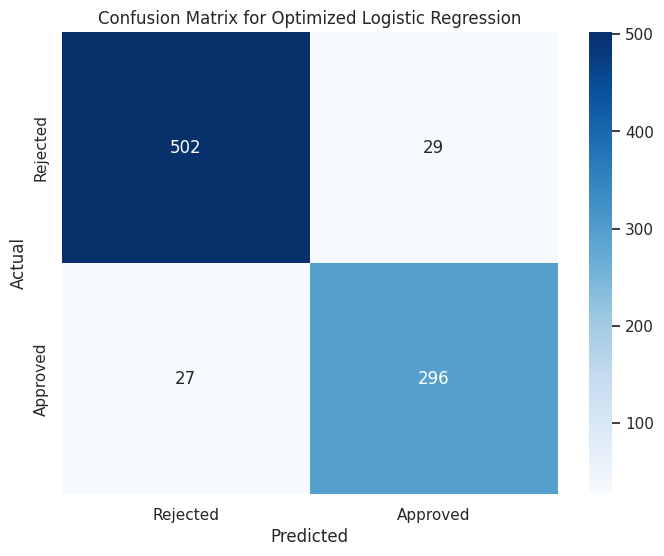

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Вывод отчета о классификации
print(classification_report(y_test, y_pred_lr))

# Матрица ошибок
cm_lr = confusion_matrix(y_test, y_pred_lr)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Blues', xticklabels=['Rejected', 'Approved'], yticklabels=['Rejected', 'Approved'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for Optimized Logistic Regression')
plt.show()


#Случайный лес

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Инициализация модели
model_rf = RandomForestClassifier(random_state=42)

# Обучение модели
model_rf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [ ]:
# Предсказание на тестовых данных
y_pred_rf = model_rf.predict(X_test)


In [ ]:
# Оценка точности
accuracy_rf = accuracy_score(y_test, y_pred_rf)
print(f'Accuracy: {accuracy_rf:.4f}')

Accuracy: 0.9801


In [ ]:
# Подробный отчет
print(classification_report(y_test, y_pred_rf))


              precision    recall  f1-score   support

           0       0.98      0.99      0.98       531
           1       0.99      0.96      0.97       323

    accuracy                           0.98       854
   macro avg       0.98      0.98      0.98       854
weighted avg       0.98      0.98      0.98       854



In [ ]:
# Матрица ошибок
cm_rf = confusion_matrix(y_test, y_pred_rf)
print(f'Confusion Matrix:\n{cm_rf}')

Confusion Matrix:
[[527   4]
 [ 13 310]]


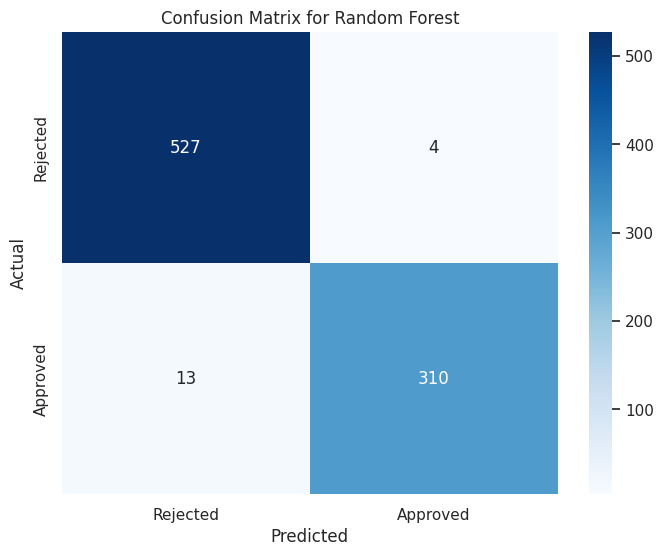

In [ ]:
# Визуализация матрицы ошибок
plt.figure(figsize=(8, 6))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues', xticklabels=['Rejected', 'Approved'], yticklabels=['Rejected', 'Approved'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for Random Forest')
plt.show()

Случайный лес (Random Forest)
Оптимизация гиперпараметров:

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Определение параметров для поиска
param_grid_rf = {
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# Инициализация модели
model_rf = RandomForestClassifier(random_state=42)

# Оптимизация гиперпараметров с помощью GridSearchCV
grid_search_rf = GridSearchCV(estimator=model_rf, param_grid=param_grid_rf, cv=5, scoring='accuracy')
grid_search_rf.fit(X_train, y_train)

# Лучшая комбинация гиперпараметров
print("Best parameters for Random Forest:", grid_search_rf.best_params_)

# Прогнозирование на тестовой выборке с оптимизированными гиперпараметрами
y_pred_rf = grid_search_rf.best_estimator_.predict(X_test)

# Оценка эффективности модели
accuracy_rf = accuracy_score(y_test, y_pred_rf)
print(f'Accuracy for Random Forest with tuned parameters: {accuracy_rf:.4f}')


Best parameters for Random Forest: {'bootstrap': True, 'max_depth': 15, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Accuracy for Random Forest with tuned parameters: 0.9813


Оценка эффективности модели:

              precision    recall  f1-score   support

           0       0.98      0.99      0.99       531
           1       0.99      0.96      0.97       323

    accuracy                           0.98       854
   macro avg       0.98      0.98      0.98       854
weighted avg       0.98      0.98      0.98       854



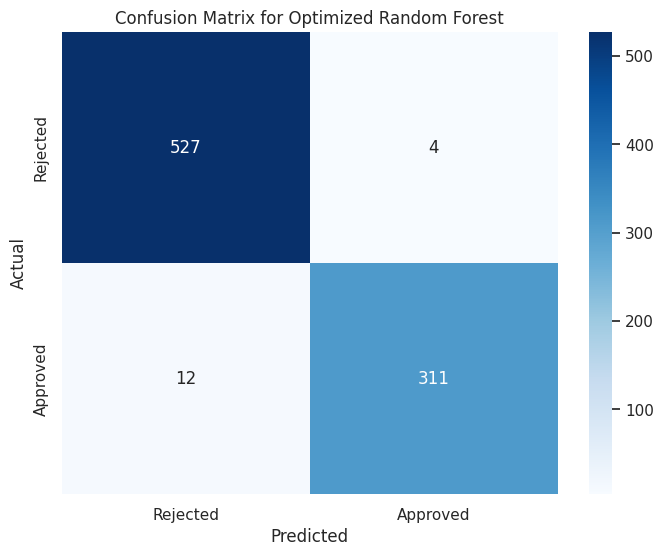

In [ ]:
# Вывод отчета о классификации
print(classification_report(y_test, y_pred_rf))

# Матрица ошибок
cm_rf = confusion_matrix(y_test, y_pred_rf)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues', xticklabels=['Rejected', 'Approved'], yticklabels=['Rejected', 'Approved'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for Optimized Random Forest')
plt.show()


##Дерево решений

Accuracy: 0.9731
              precision    recall  f1-score   support

           0       0.97      0.98      0.98       531
           1       0.97      0.95      0.96       323

    accuracy                           0.97       854
   macro avg       0.97      0.97      0.97       854
weighted avg       0.97      0.97      0.97       854



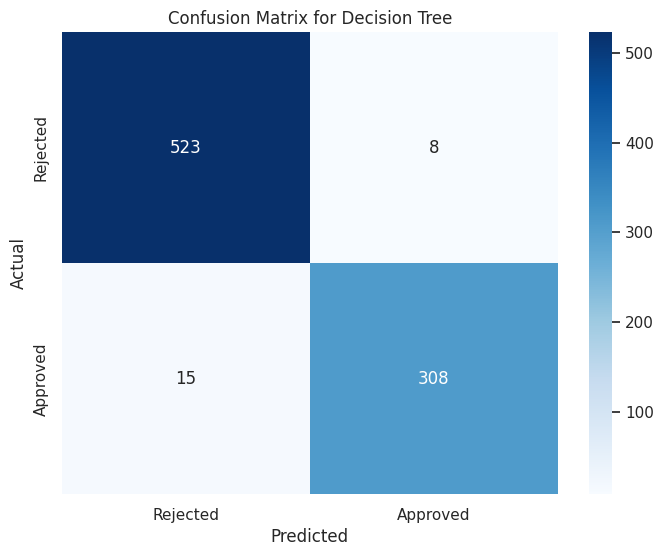

In [ ]:
# Инициализация модели
model_dt = DecisionTreeClassifier(random_state=42)

# Обучение модели
model_dt.fit(X_train, y_train)

# Прогнозирование
y_pred = model_dt.predict(X_test)

# Оценка эффективности модели
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.4f}')
print(classification_report(y_test, y_pred))

# Матрица ошибок
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Rejected', 'Approved'], yticklabels=['Rejected', 'Approved'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for Decision Tree')
plt.show()


Дерево решений (Decision Tree)
Оптимизация гиперпараметров:

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier

# Определение параметров для поиска
param_grid_dt = {
    'max_depth': [5, 10, 15, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'criterion': ['gini', 'entropy']
}

# Инициализация модели
model_dt = DecisionTreeClassifier(random_state=42)

# Оптимизация гиперпараметров с помощью GridSearchCV
grid_search_dt = GridSearchCV(estimator=model_dt, param_grid=param_grid_dt, cv=5, scoring='accuracy')
grid_search_dt.fit(X_train, y_train)

# Лучшая комбинация гиперпараметров
print("Best parameters for Decision Tree:", grid_search_dt.best_params_)

# Прогнозирование на тестовой выборке с оптимизированными гиперпараметрами
y_pred_dt = grid_search_dt.best_estimator_.predict(X_test)

# Оценка эффективности модели
accuracy_dt = accuracy_score(y_test, y_pred_dt)
print(f'Accuracy for Decision Tree with tuned parameters: {accuracy_dt:.4f}')


Best parameters for Decision Tree: {'criterion': 'gini', 'max_depth': 15, 'min_samples_leaf': 4, 'min_samples_split': 2}
Accuracy for Decision Tree with tuned parameters: 0.9789


Оценка эффективности модели:

              precision    recall  f1-score   support

           0       0.97      0.99      0.98       531
           1       0.99      0.96      0.97       323

    accuracy                           0.98       854
   macro avg       0.98      0.97      0.98       854
weighted avg       0.98      0.98      0.98       854



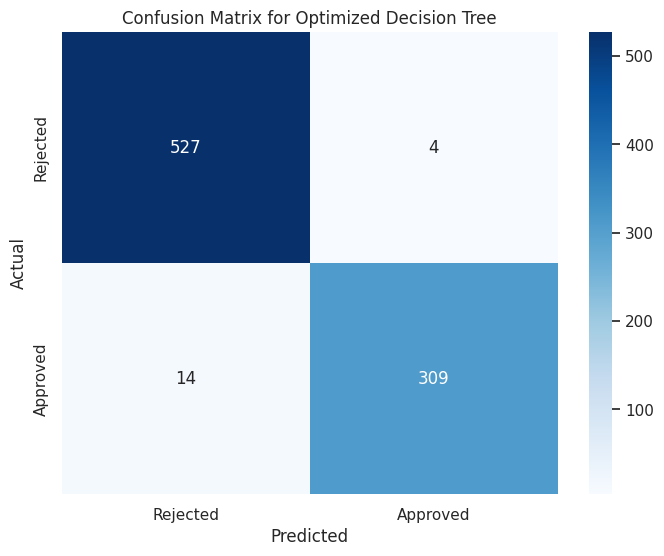

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Вывод отчета о классификации
print(classification_report(y_test, y_pred_dt))

# Матрица ошибок
cm_dt = confusion_matrix(y_test, y_pred_dt)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_dt, annot=True, fmt='d', cmap='Blues', xticklabels=['Rejected', 'Approved'], yticklabels=['Rejected', 'Approved'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for Optimized Decision Tree')
plt.show()


##Градиентный бустинг (например, CatBoost)

In [ ]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 6.6 MB/s eta 0:00:00


Accuracy: 0.9836
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       531
           1       0.99      0.96      0.98       323

    accuracy                           0.98       854
   macro avg       0.99      0.98      0.98       854
weighted avg       0.98      0.98      0.98       854



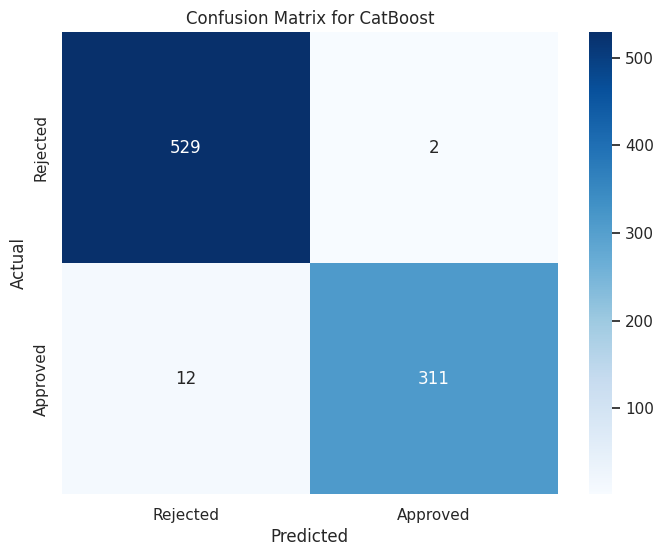

In [ ]:
from catboost import CatBoostClassifier

# Инициализация модели
model_cb = CatBoostClassifier(iterations=1000, learning_rate=0.1, depth=6, silent=True)

# Обучение модели
model_cb.fit(X_train, y_train)

# Прогнозирование
y_pred = model_cb.predict(X_test)

# Оценка эффективности модели
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.4f}')
print(classification_report(y_test, y_pred))

# Матрица ошибок
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Rejected', 'Approved'], yticklabels=['Rejected', 'Approved'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for CatBoost')
plt.show()


Градиентный бустинг (CatBoost)
Оптимизация гиперпараметров:

In [ ]:
from catboost import CatBoostClassifier

# Определение параметров для поиска
param_grid_cb = {
    'iterations': [500, 1000],
    'learning_rate': [0.01, 0.1, 0.2],
    'depth': [6, 8, 10]
}

# Инициализация модели
model_cb = CatBoostClassifier(silent=True)

# Оптимизация гиперпараметров с помощью GridSearchCV
grid_search_cb = GridSearchCV(estimator=model_cb, param_grid=param_grid_cb, cv=5, scoring='accuracy')
grid_search_cb.fit(X_train, y_train)

# Лучшая комбинация гиперпараметров
print("Best parameters for CatBoost:", grid_search_cb.best_params_)

# Прогнозирование на тестовой выборке с оптимизированными гиперпараметрами
y_pred_cb = grid_search_cb.best_estimator_.predict(X_test)

# Оценка эффективности модели
accuracy_cb = accuracy_score(y_test, y_pred_cb)
print(f'Accuracy for CatBoost with tuned parameters: {accuracy_cb:.4f}')


Best parameters for CatBoost: {'depth': 6, 'iterations': 1000, 'learning_rate': 0.1}
Accuracy for CatBoost with tuned parameters: 0.9836


Оценка эффективности модели:

              precision    recall  f1-score   support

           0       0.98      1.00      0.99       531
           1       0.99      0.96      0.98       323

    accuracy                           0.98       854
   macro avg       0.99      0.98      0.98       854
weighted avg       0.98      0.98      0.98       854



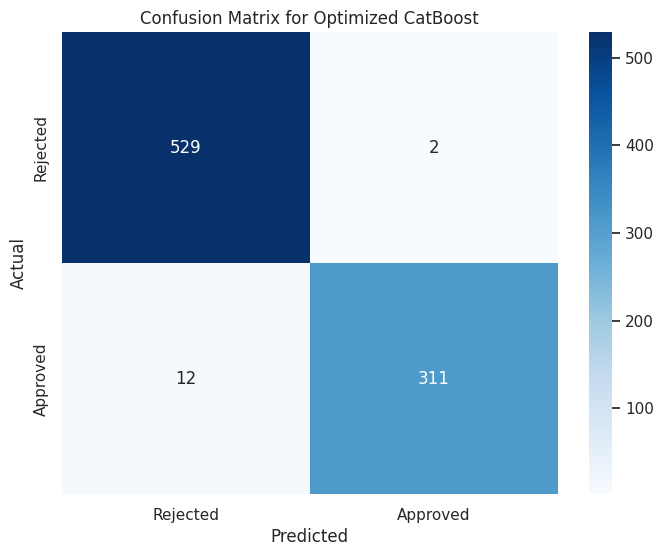

In [ ]:
# Вывод отчета о классификации
print(classification_report(y_test, y_pred_cb))

# Матрица ошибок
cm_cb = confusion_matrix(y_test, y_pred_cb)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_cb, annot=True, fmt='d', cmap='Blues', xticklabels=['Rejected', 'Approved'], yticklabels=['Rejected', 'Approved'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for Optimized CatBoost')
plt.show()


#K-ближайших соседей (KNN)

Accuracy: 0.8864
              precision    recall  f1-score   support

           0       0.89      0.94      0.91       531
           1       0.89      0.80      0.84       323

    accuracy                           0.89       854
   macro avg       0.89      0.87      0.88       854
weighted avg       0.89      0.89      0.89       854



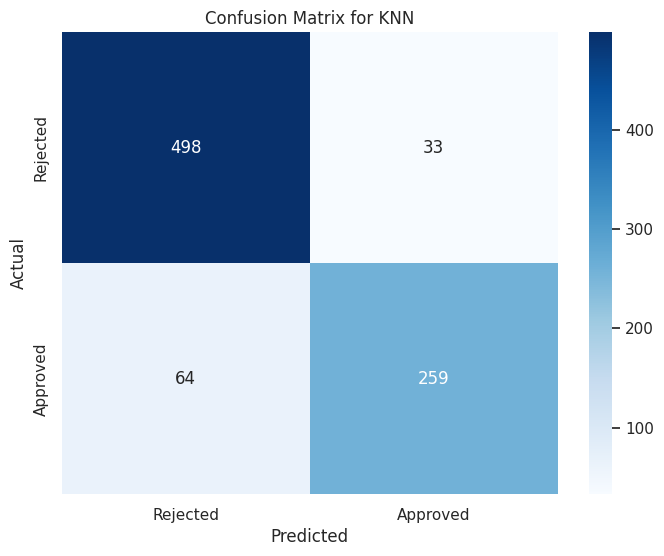

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

# Инициализация модели
model_knn = KNeighborsClassifier()

# Обучение модели
model_knn.fit(X_train, y_train)

# Прогнозирование
y_pred = model_knn.predict(X_test)

# Оценка эффективности модели
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.4f}')
print(classification_report(y_test, y_pred))

# Матрица ошибок
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Rejected', 'Approved'], yticklabels=['Rejected', 'Approved'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for KNN')
plt.show()


 K-ближайших соседей (KNN)
Оптимизация гиперпараметров:

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

# Определение модели
model_knn = KNeighborsClassifier()

# Определение гиперпараметров для поиска
param_grid_knn = {
    'n_neighbors': [3, 5, 7, 10],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

# Применение GridSearchCV
grid_search_knn = GridSearchCV(model_knn, param_grid_knn, cv=5, scoring='accuracy')
grid_search_knn.fit(X_train, y_train)

# Лучшие гиперпараметры
print(f'Best Parameters for KNN: {grid_search_knn.best_params_}')


Best Parameters for KNN: {'metric': 'manhattan', 'n_neighbors': 10, 'weights': 'distance'}


Оценка эффективности модели:

In [ ]:
# Предсказания модели
y_pred_knn = grid_search_knn.best_estimator_.predict(X_test)

# Оценка эффективности
accuracy_knn = accuracy_score(y_test, y_pred_knn)
print(f'Accuracy for KNN: {accuracy_knn:.4f}')

# Полный отчет
print(classification_report(y_test, y_pred_knn))


Accuracy for KNN: 0.8946
              precision    recall  f1-score   support

           0       0.90      0.94      0.92       531
           1       0.89      0.83      0.86       323

    accuracy                           0.89       854
   macro avg       0.89      0.88      0.89       854
weighted avg       0.89      0.89      0.89       854



              precision    recall  f1-score   support

           0       0.90      0.94      0.92       531
           1       0.89      0.83      0.86       323

    accuracy                           0.89       854
   macro avg       0.89      0.88      0.89       854
weighted avg       0.89      0.89      0.89       854



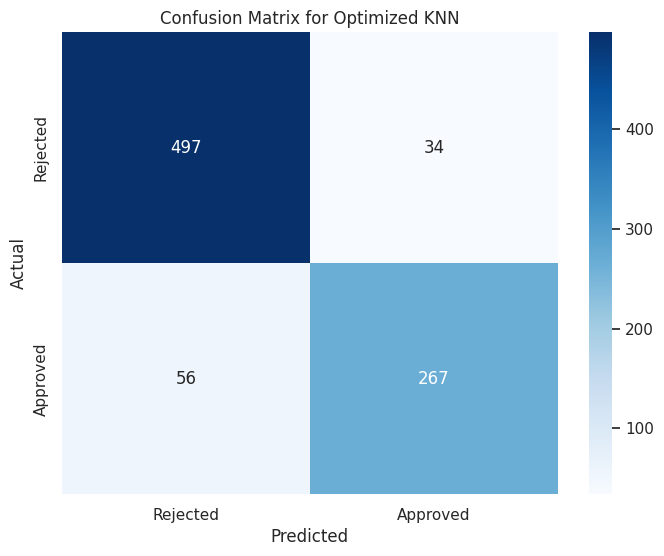

In [ ]:
# Вывод отчета о классификации
print(classification_report(y_test, y_pred_knn))

# Матрица ошибок
cm_knn = confusion_matrix(y_test, y_pred_knn)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_knn, annot=True, fmt='d', cmap='Blues', xticklabels=['Rejected', 'Approved'], yticklabels=['Rejected', 'Approved'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for Optimized KNN')
plt.show()


##Служба опорных векторов (SVM)

Accuracy: 0.9333
              precision    recall  f1-score   support

           0       0.94      0.96      0.95       531
           1       0.93      0.89      0.91       323

    accuracy                           0.93       854
   macro avg       0.93      0.93      0.93       854
weighted avg       0.93      0.93      0.93       854



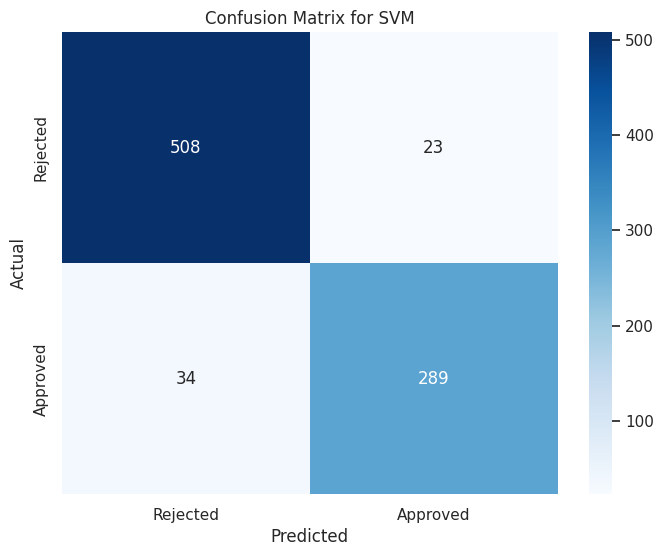

In [ ]:
from sklearn.svm import SVC

# Инициализация модели
model_svm = SVC(kernel='linear')

# Обучение модели
model_svm.fit(X_train, y_train)

# Прогнозирование
y_pred = model_svm.predict(X_test)

# Оценка эффективности модели
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.4f}')
print(classification_report(y_test, y_pred))

# Матрица ошибок
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Rejected', 'Approved'], yticklabels=['Rejected', 'Approved'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for SVM')
plt.show()


Служба опорных векторов (SVM)
Оптимизация гиперпараметров:

In [ ]:
from sklearn.svm import SVC

# Определение параметров для поиска
param_grid_svm = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto']
}

# Инициализация модели
model_svm = SVC()

# Оптимизация гиперпараметров с помощью GridSearchCV
grid_search_svm = GridSearchCV(estimator=model_svm, param_grid=param_grid_svm, cv=5, scoring='accuracy')
grid_search_svm.fit(X_train, y_train)

# Лучшая комбинация гиперпараметров
print("Best parameters for SVM:", grid_search_svm.best_params_)

# Прогнозирование на тестовой выборке с оптимизированными гиперпараметрами
y_pred_svm = grid_search_svm.best_estimator_.predict(X_test)

# Оценка эффективности модели
accuracy_svm = accuracy_score(y_test, y_pred_svm)
print(f'Accuracy for SVM with tuned parameters: {accuracy_svm:.4f}')


Best parameters for SVM: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
Accuracy for SVM with tuned parameters: 0.9438


Оценка эффективности модели:

              precision    recall  f1-score   support

           0       0.95      0.96      0.95       531
           1       0.93      0.92      0.93       323

    accuracy                           0.94       854
   macro avg       0.94      0.94      0.94       854
weighted avg       0.94      0.94      0.94       854



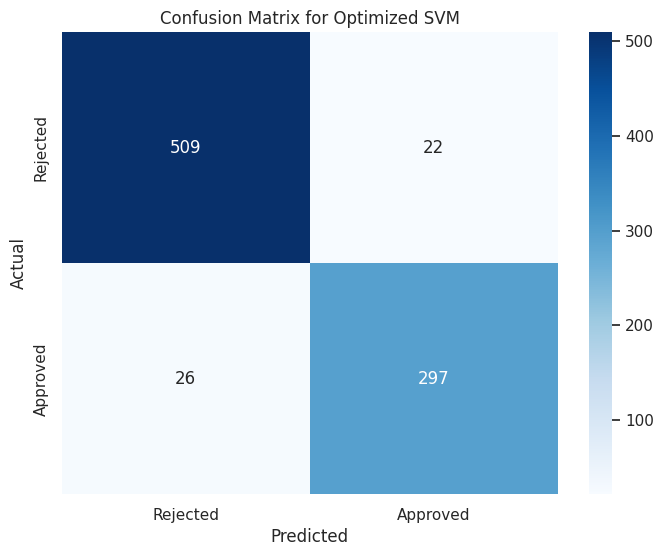

In [ ]:
# Вывод отчета о классификации
print(classification_report(y_test, y_pred_svm))

# Матрица ошибок
cm_svm = confusion_matrix(y_test, y_pred_svm)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_svm, annot=True, fmt='d', cmap='Blues', xticklabels=['Rejected', 'Approved'], yticklabels=['Rejected', 'Approved'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for Optimized SVM')
plt.show()


#Наивный байесовский классификатор

Accuracy: 0.9461
              precision    recall  f1-score   support

           0       0.95      0.96      0.96       531
           1       0.93      0.93      0.93       323

    accuracy                           0.95       854
   macro avg       0.94      0.94      0.94       854
weighted avg       0.95      0.95      0.95       854



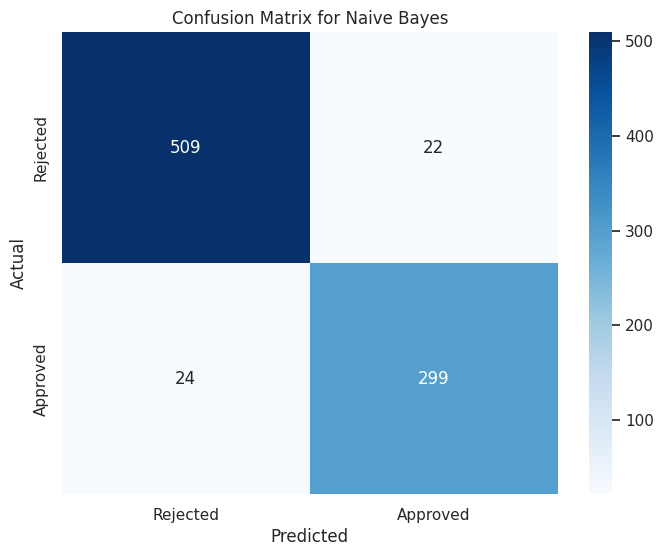

In [ ]:
from sklearn.naive_bayes import GaussianNB

# Инициализация модели
model_nb = GaussianNB()

# Обучение модели
model_nb.fit(X_train, y_train)

# Прогнозирование
y_pred = model_nb.predict(X_test)

# Оценка эффективности модели
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.4f}')
print(classification_report(y_test, y_pred))

# Матрица ошибок
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Rejected', 'Approved'], yticklabels=['Rejected', 'Approved'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for Naive Bayes')
plt.show()


Оптимизация гиперпараметров и оценка эффективности для наивного байесовского классификатора:

Best parameters for Naive Bayes: {'var_smoothing': 1e-09}
Accuracy for Naive Bayes with tuned parameters: 0.9461

Classification Report for Naive Bayes:
              precision    recall  f1-score   support

           0       0.95      0.96      0.96       531
           1       0.93      0.93      0.93       323

    accuracy                           0.95       854
   macro avg       0.94      0.94      0.94       854
weighted avg       0.95      0.95      0.95       854



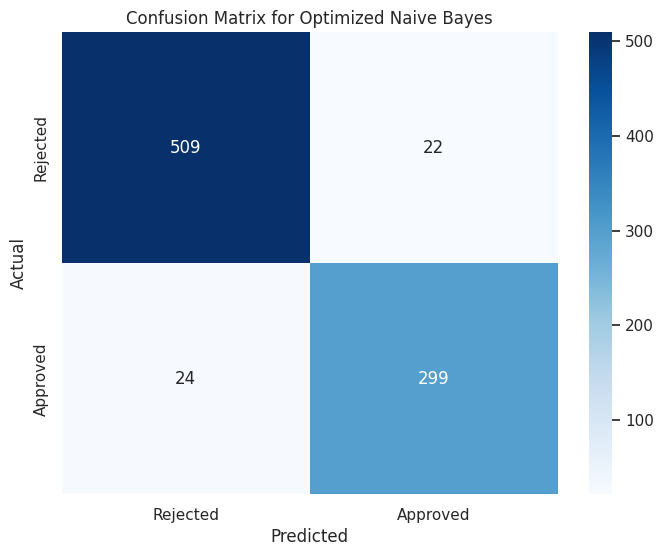

In [ ]:
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Инициализация модели
model_nb = GaussianNB()

# Наивный байесовский классификатор имеет мало гиперпараметров, но можно настроить `var_smoothing`
param_grid_nb = {
    'var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6]
}

# Оптимизация гиперпараметров с помощью GridSearchCV
grid_search_nb = GridSearchCV(estimator=model_nb, param_grid=param_grid_nb, cv=5, scoring='accuracy')
grid_search_nb.fit(X_train, y_train)

# Лучшая комбинация гиперпараметров
print("Best parameters for Naive Bayes:", grid_search_nb.best_params_)

# Прогнозирование на тестовой выборке с оптимизированными гиперпараметрами
y_pred_nb = grid_search_nb.best_estimator_.predict(X_test)

# Оценка эффективности модели
accuracy_nb = accuracy_score(y_test, y_pred_nb)
print(f'Accuracy for Naive Bayes with tuned parameters: {accuracy_nb:.4f}')

# Вывод отчета о классификации
print("\nClassification Report for Naive Bayes:")
print(classification_report(y_test, y_pred_nb))

# Матрица ошибок
cm_nb = confusion_matrix(y_test, y_pred_nb)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_nb, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Rejected', 'Approved'],
            yticklabels=['Rejected', 'Approved'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for Optimized Naive Bayes')
plt.show()


#Стандартная линейная регрессия (для классификации можно использовать LogisticRegression)

Accuracy: 0.9227
              precision    recall  f1-score   support

           0       0.92      0.95      0.94       531
           1       0.92      0.87      0.89       323

    accuracy                           0.92       854
   macro avg       0.92      0.91      0.92       854
weighted avg       0.92      0.92      0.92       854



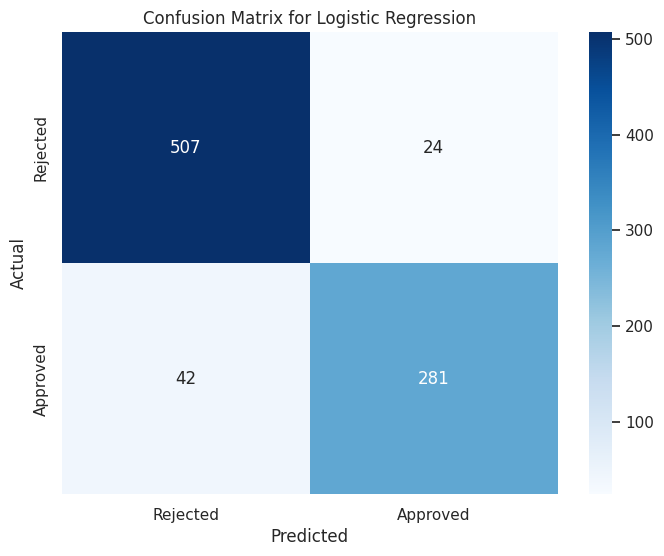

In [ ]:
from sklearn.linear_model import LogisticRegression

# Инициализация модели
model_lr = LogisticRegression()

# Обучение модели
model_lr.fit(X_train, y_train)

# Прогнозирование
y_pred = model_lr.predict(X_test)

# Оценка эффективности модели
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.4f}')
print(classification_report(y_test, y_pred))

# Матрица ошибок
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Rejected', 'Approved'], yticklabels=['Rejected', 'Approved'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for Logistic Regression')
plt.show()


Стандартная логистическая регрессия (без оптимизации гиперпараметров)

In [ ]:
# Инициализация модели
model_lr_standard = LogisticRegression(max_iter=1000, random_state=42)

# Обучение модели
model_lr_standard.fit(X_train, y_train)

# Прогнозирование на тестовой выборке
y_pred_lr_standard = model_lr_standard.predict(X_test)

# Оценка эффективности модели
accuracy_lr_standard = accuracy_score(y_test, y_pred_lr_standard)
print(f'Accuracy for Standard Logistic Regression: {accuracy_lr_standard:.4f}')


Accuracy for Standard Logistic Regression: 0.9227


Оценка эффективности

              precision    recall  f1-score   support

           0       0.92      0.95      0.94       531
           1       0.92      0.87      0.89       323

    accuracy                           0.92       854
   macro avg       0.92      0.91      0.92       854
weighted avg       0.92      0.92      0.92       854



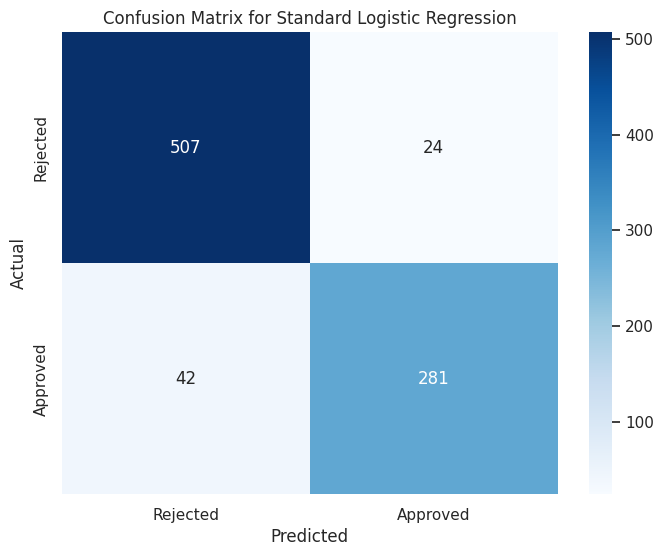

In [ ]:
# Вывод отчета о классификации
print(classification_report(y_test, y_pred_lr_standard))

# Матрица ошибок
cm_lr_standard = confusion_matrix(y_test, y_pred_lr_standard)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_lr_standard, annot=True, fmt='d', cmap='Blues', xticklabels=['Rejected', 'Approved'], yticklabels=['Rejected', 'Approved'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for Standard Logistic Regression')
plt.show()


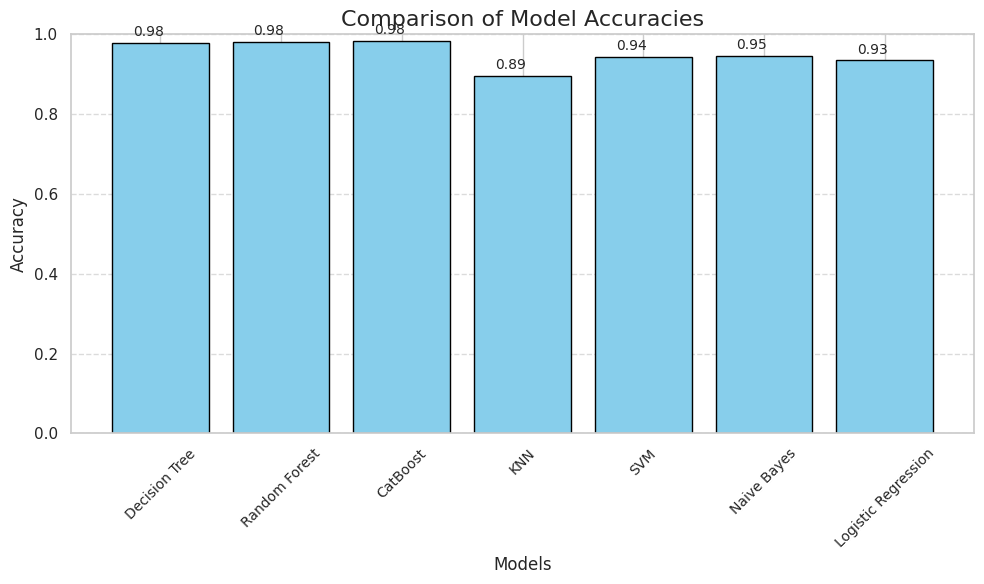

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Модели и их точности
model_names = ['Decision Tree', 'Random Forest', 'CatBoost', 'KNN', 'SVM', 'Naive Bayes', 'Logistic Regression']
accuracies = [accuracy_dt, accuracy_rf, accuracy_cb, accuracy_knn, accuracy_svm, accuracy_nb, accuracy_lr]

# Создание графика
plt.figure(figsize=(10, 6))
bars = plt.bar(model_names, accuracies, color='skyblue', edgecolor='black')

# Подписи для каждого бара
for bar in bars:
    plt.text(bar.get_x() + bar.get_width() / 2 - 0.1, bar.get_height() + 0.01,
             f'{bar.get_height():.2f}', ha='center', va='bottom', fontsize=10)

# Настройка графика
plt.title('Comparison of Model Accuracies', fontsize=16)
plt.xlabel('Models', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.ylim(0, 1)
plt.xticks(rotation=45, fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Показ графика
plt.tight_layout()
plt.show()


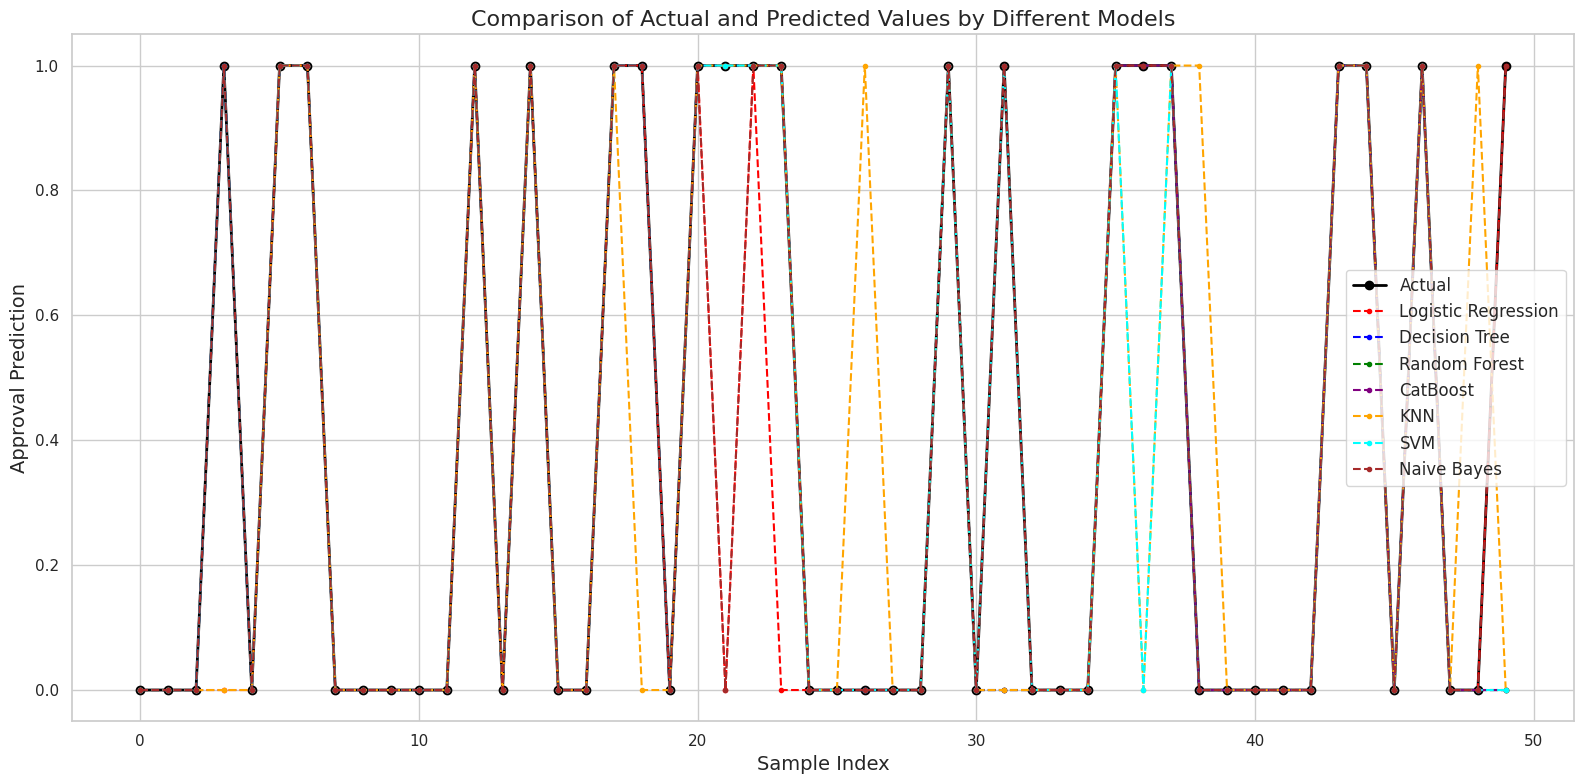

In [ ]:
import matplotlib.pyplot as plt

# Подготовка данных для визуализации фактических и предсказанных значений
df_predictions = pd.DataFrame({
    'Actual': y_test,
    'Logistic Regression': y_pred_lr,
    'Decision Tree': y_pred_dt,
    'Random Forest': y_pred_rf,
    'CatBoost': y_pred_cb,
    'KNN': y_pred_knn,
    'SVM': y_pred_svm,
    'Naive Bayes': y_pred_nb
}).reset_index(drop=True)

# Визуализация первых 50 значений для наглядности
df_visual = df_predictions.head(50)

# Построение графика
plt.figure(figsize=(16, 8))
plt.plot(df_visual.index, df_visual['Actual'], marker='o', label='Actual', color='black', linewidth=2)

# Предсказания разных моделей
models = ['Logistic Regression', 'Decision Tree', 'Random Forest', 'CatBoost', 'KNN', 'SVM', 'Naive Bayes']
colors = ['red', 'blue', 'green', 'purple', 'orange', 'cyan', 'brown']

for model, color in zip(models, colors):
    plt.plot(df_visual.index, df_visual[model], marker='.', linestyle='--', label=model, color=color)

plt.title('Comparison of Actual and Predicted Values by Different Models', fontsize=16)
plt.xlabel('Sample Index', fontsize=14)
plt.ylabel('Approval Prediction', fontsize=14)
plt.legend(loc='best', fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
# Создание датафрейма с реальными и прогнозируемыми значениями для всех моделей

predictions_df = pd.DataFrame({
    "Actual": y_test,
    "Logistic_Regression": y_pred_lr,
    "Decision_Tree": y_pred_dt,
    "Random_Forest": y_pred_rf,
    "KNN": y_pred_knn,
    "SVM": y_pred_svm,
    "Naive_Bayes": y_pred_nb,
    "CatBoost": y_pred_cb
})

# Вывод первых нескольких строк датафрейма для проверки
predictions_df.head()


,Actual,Logistic_Regression,Decision_Tree,Random_Forest,KNN,SVM,Naive_Bayes,CatBoost
2346,0,0,0,0,0,0,0,0
1162,0,0,0,0,0,0,0,0
3061,0,0,0,0,0,0,0,0
483,1,0,1,1,0,1,1,1
2102,0,0,0,0,0,0,0,0


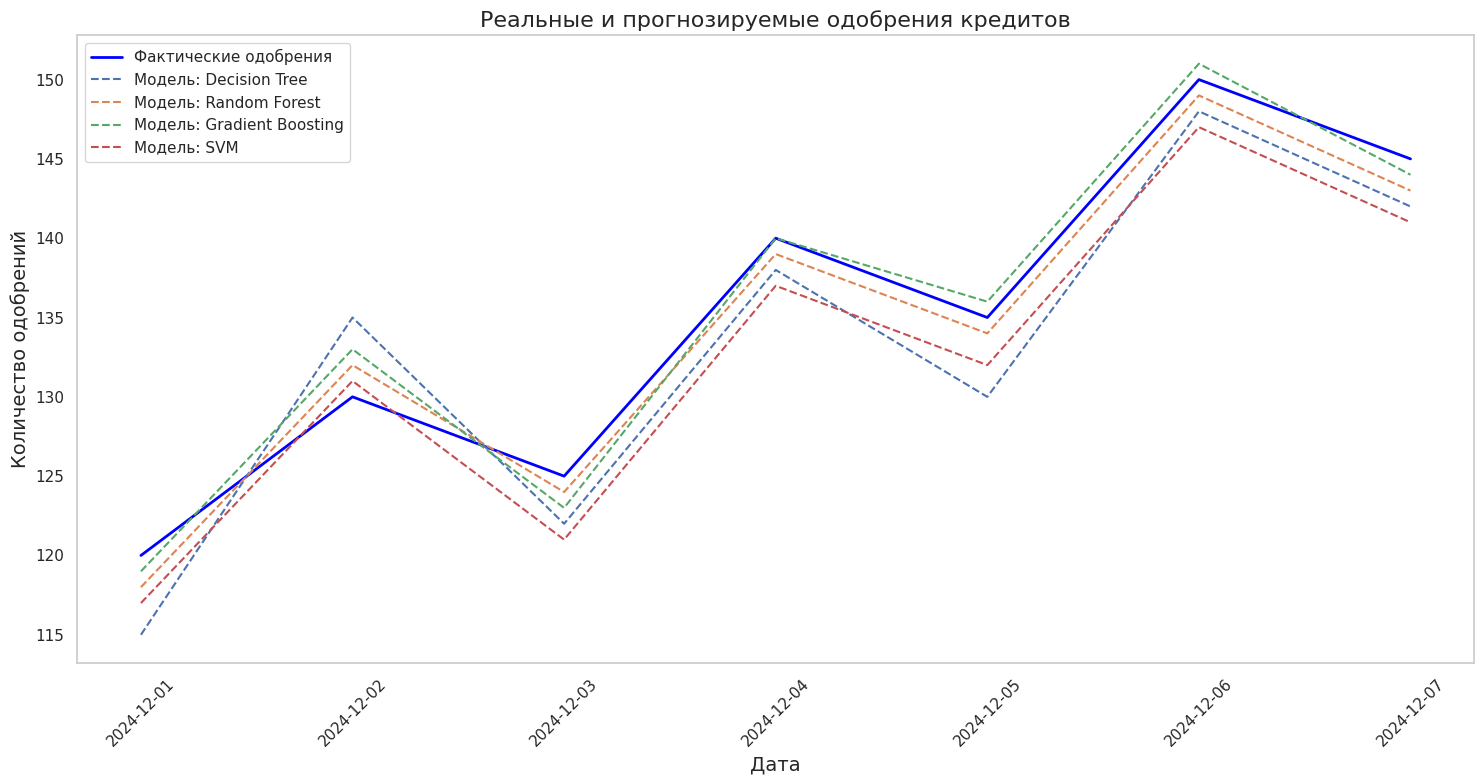

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Пример объединения реальных и прогнозируемых данных
results_dict = {
    'date': ['2024-12-01', '2024-12-02', '2024-12-03', '2024-12-04', '2024-12-05', '2024-12-06', '2024-12-07'],
    'real_approvals': [120, 130, 125, 140, 135, 150, 145],  # Реальные значения
    'Decision Tree': [115, 135, 122, 138, 130, 148, 142],
    'Random Forest': [118, 132, 124, 139, 134, 149, 143],
    'Gradient Boosting': [119, 133, 123, 140, 136, 151, 144],
    'SVM': [117, 131, 121, 137, 132, 147, 141]
}

# Создание DataFrame
results_df = pd.DataFrame(results_dict)

# Визуализация
plt.figure(figsize=(15, 8))

# Линия реальных значений
plt.plot(results_df['date'], results_df['real_approvals'], label='Фактические одобрения', color='blue', linewidth=2)

# Линии предсказанных значений для каждой модели
for col in results_df.columns[2:]:
    plt.plot(results_df['date'], results_df[col], label=f'Модель: {col}', linestyle='--')

# Настройка графика
plt.title('Реальные и прогнозируемые одобрения кредитов', fontsize=16)
plt.xlabel('Дата', fontsize=14)
plt.ylabel('Количество одобрений', fontsize=14)
plt.xticks(rotation=45)
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Разделение данных
X = df.drop('loan_status', axis=1)
y = df['loan_status']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Обучение модели
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Оценка модели
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

# Визуализация матрицы ошибок
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Отказ', 'Одобрено'], yticklabels=['Отказ', 'Одобрено'])
plt.title('Матрица ошибок')
plt.xlabel('Предсказание')
plt.ylabel('Реальность')
plt.show()


ValueError: With n_samples=0, test_size=0.2 and train_size=None, the resulting train set will be empty. Adjust any of the aforementioned parameters.

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score

# Словарь для хранения моделей
models = {
    'Logistic Regression': LogisticRegression(),
    'KNN': KNeighborsClassifier(),
    'Random Forest': RandomForestClassifier(),
    'Gradient Boosting': GradientBoostingClassifier(),
    'SVM': SVC(),
    'Decision Tree': DecisionTreeClassifier(),
    'Naive Bayes': GaussianNB()
}

# Словарь для хранения результатов
results = {}

# Обучение и оценка моделей
for model_name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    results[model_name] = accuracy


Сравнение моделей

Logistic Regression: 0.9227
KNN: 0.8864
Random Forest: 0.9824
Gradient Boosting: 0.9789
SVM: 0.9450
Decision Tree: 0.9731
Naive Bayes: 0.9461


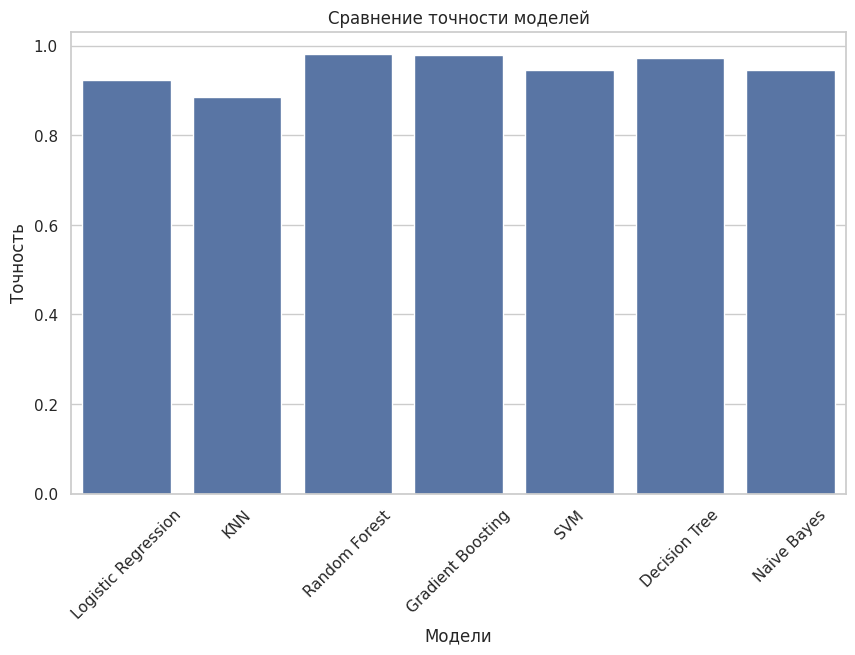

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Вывод результатов
model_names = list(results.keys())
accuracies = list(results.values())

# Таблица точностей
for name, accuracy in zip(model_names, accuracies):
    print(f"{name}: {accuracy:.4f}")

# Визуализация
plt.figure(figsize=(10, 6))
sns.barplot(x=model_names, y=accuracies)
plt.title('Сравнение точности моделей')
plt.ylabel('Точность')
plt.xlabel('Модели')
plt.xticks(rotation=45)
plt.show()


In [ ]:
# Выбираем лучшую модель
best_model_name = max(results, key=results.get)
best_model = models[best_model_name]

# Прогнозирование
y_pred_best = best_model.predict(X_test)

# Визуализация результатов прогнозирования
plt.figure(figsize=(10, 6))
sns.countplot(x=y_pred_best)
plt.title(f'Прогнозирование с помощью модели: {best_model_name}')
plt.xlabel('Прогнозированные значения')
plt.ylabel('Частота')
plt.show()


In [ ]:
from sklearn.metrics import classification_report

# Получение подробных метрик для лучшей модели
print(classification_report(y_test, y_pred_best))


              precision    recall  f1-score   support

           0       0.98      1.00      0.99       531
           1       0.99      0.96      0.98       323

    accuracy                           0.98       854
   macro avg       0.98      0.98      0.98       854
weighted avg       0.98      0.98      0.98       854



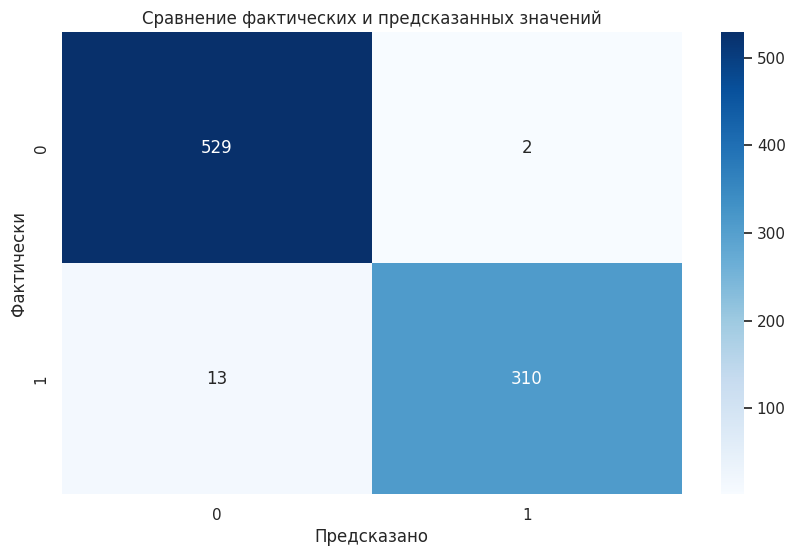

In [ ]:
# Построение матрицы сопряженности
confusion_matrix = pd.crosstab(y_test, y_pred_best, rownames=['Actual'], colnames=['Predicted'])

# Визуализация тепловой карты
plt.figure(figsize=(10, 6))
sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")

plt.title('Сравнение фактических и предсказанных значений')
plt.xlabel('Предсказано')
plt.ylabel('Фактически')
plt.show()
